In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from util.collision_loss import center_param_collision_check, center_param_collision_loss
from util.zonotope import Zonotope
from util.constrained_zonotope import ConstrainedZonotope

# Collision check

collision check:  tensor(1.0000, grad_fn=<_CvxpyLayerFnFnBackward>)


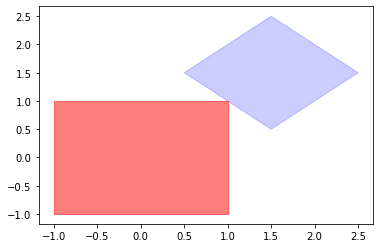

In [2]:
c_out_tch = 1.5*torch.ones(2, 1, requires_grad=True)
G_out = np.array([[0.5, 0.5],[-0.5, 0.5]])
obstacle = Zonotope(np.zeros((2,1)), np.eye(2))
v = center_param_collision_check(c_out_tch, G_out, obstacle)
print("collision check: ", v)
fig, ax = plt.subplots()
obstacle.plot(ax=ax, color='r')
Z_out = Zonotope(c_out_tch.detach().numpy(), G_out)
Z_out.plot(ax=ax, alpha=0.2)

# Gradient updates to push out of collision

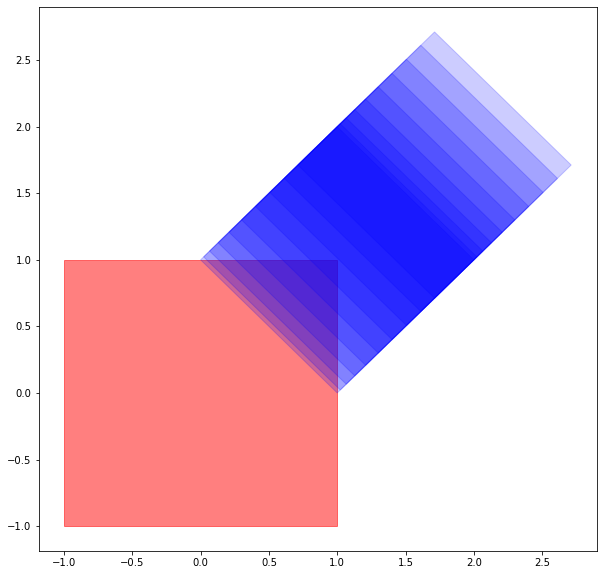

In [3]:
c_out = torch.ones(2, 1, requires_grad=True)
G_out = np.array([[0.5, 0.5],[-0.5, 0.5]])
obstacle = Zonotope(np.zeros((2,1)), np.eye(2))

num_iters = 10
learning_rate = 0.1

fig, ax = plt.subplots(figsize=(10,10))
obstacle.plot(ax=ax, color='r')

# gradient updates:
for i in range(num_iters):
    #c_out.grad.zero_()   # zero the gradient buffers

    # plot the current zonotope
    Z_out = Zonotope(c_out.detach().numpy(), G_out)
    Z_out.plot(ax=ax, alpha=0.2)

    # compute loss and gradient
    loss = center_param_collision_loss(c_out, G_out, obstacle)
    loss.backward()

    # apply gradient update
    c_out.data.sub_(c_out.grad.data * learning_rate)
    

# Feedforward network

In [5]:
# 3 Layer ReLU Feedforward Network
# Output: zonotope of dimension 2, order 2 (6 total parameters)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(4, 16)  # 5*5 from image dimension
        self.fc2 = nn.Linear(16, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


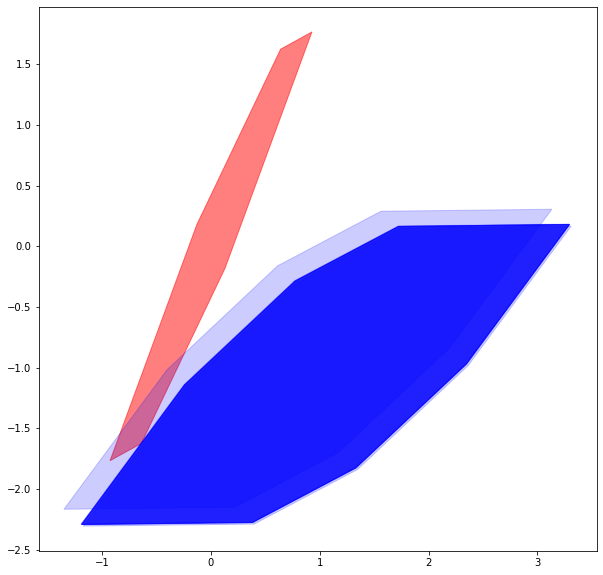

In [7]:
# arbitary input
inpt = torch.tensor([1,2,3,4], dtype=torch.float)

G_out = np.random.rand(2,4)
obstacle = Zonotope(np.zeros((2,1)), np.random.rand(2,3))

# "train" the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

num_iters = 10

fig, ax = plt.subplots(figsize=(10,10))
obstacle.plot(ax=ax, color='r')

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    # generate a new zonotope (center) from the network
    out = net(inpt)
    out = torch.reshape(out, (2,1))

    # plot the resulting zonotope
    Z_out = Zonotope(out.detach().numpy(), G_out)
    Z_out.plot(ax=ax, alpha=0.2)

    loss = center_param_collision_loss(out, G_out, obstacle)
    loss.backward()
    optimizer.step() 